# Check TFRECORD
Check hasil konversi dataset format csv ke tfrecord dengan menampilkan gambar, box, dan label

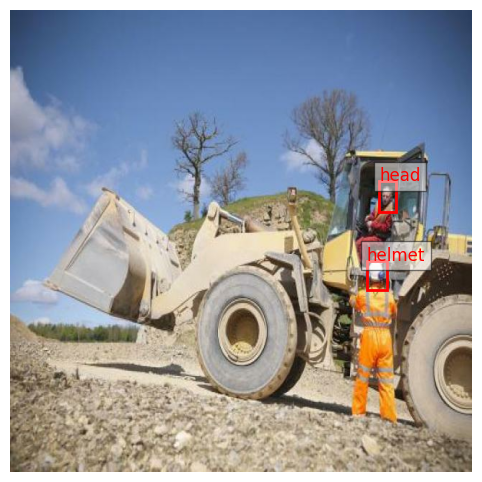

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Load TFRecord file
tfrecord_path = "hardhat_val.tfrecord"

def parse_tfrecord_fn(example_proto):
    feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    return example

def decode_image_and_boxes(example):
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    height = example['image/height']
    width = example['image/width']
    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(example['image/object/class/text'])
    return image, height, width, xmin, xmax, ymin, ymax, labels



dataset = tf.data.TFRecordDataset(tfrecord_path)

# Parse the TFRecord
parsed_dataset = dataset.map(parse_tfrecord_fn)

# Inspect the parsed TFRecord
for example in parsed_dataset.take(1):  # Take one example for inspection
    image, height, width, xmin, xmax, ymin, ymax, labels = decode_image_and_boxes(example)
    
    # Plot image
    plt.figure(figsize=(8, 6))
    plt.imshow(image.numpy())
    
    # Add bounding boxes
    for i in range(len(xmin)):
        xmin_i = int(xmin[i] * width.numpy())
        xmax_i = int(xmax[i] * width.numpy())
        ymin_i = int(ymin[i] * height.numpy())
        ymax_i = int(ymax[i] * height.numpy())
        label = labels[i].numpy().decode('utf-8')
        rect = patches.Rectangle((xmin_i, ymin_i), xmax_i - xmin_i, ymax_i - ymin_i, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin_i, ymin_i, label, color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        
    plt.axis('off')
    plt.show()